In [1]:
%matplotlib inline

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tqdm

import astropy.stats as aps

import aviary

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load data and make cuts.

31357
(21618, 134) no visual binaries or subgiants
(20880, 134) no large vb uncertainties
(20693, 134) no faint stars
(20692, 134) no hot or cold stars
(14750, 134) no high latitude stars


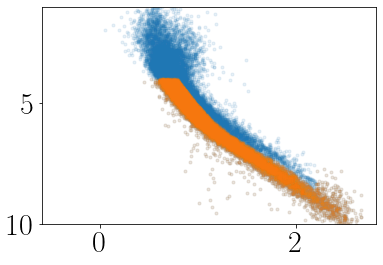

In [3]:
gaia_mc0 = pd.read_csv("../../data/gaia_mc5.csv")
print(len(gaia_mc0))

travis = pd.read_csv("../../data/Ruth_McQuillan_Masses_Out.csv")
masses = pd.DataFrame(dict({"kepid": travis.KIC.values, "Mass": travis.iso_mass.values}))
masses.head()
gaia_mc0 = pd.merge(masses, gaia_mc0, how="right", on="kepid", suffixes=["_berger", ""])

# Cut out photometric binaries.
m = gaia_mc0.flag.values == 1
gaia_mc1 = gaia_mc0.iloc[m]*1
print(np.shape(gaia_mc1), "no visual binaries or subgiants")
# gaia_mc1 = gaia_mc0*1

plt.plot(gaia_mc0.bp_dered - gaia_mc0.rp_dered, gaia_mc0.abs_G, ".", alpha=.1)
plt.plot(gaia_mc1.bp_dered - gaia_mc1.rp_dered, gaia_mc1.abs_G, ".", alpha=.1)
plt.ylim(10, 1)

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
# m &= gaia_mc1.age.values > .5
# print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3000, 6500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
bmax = 15
m &= (gaia_mc1.b.values < bmax)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

gaia_mc = gaia_mc1.iloc[m]

For each point, calculate the velocity dispersion over a grid in period-Teff space.

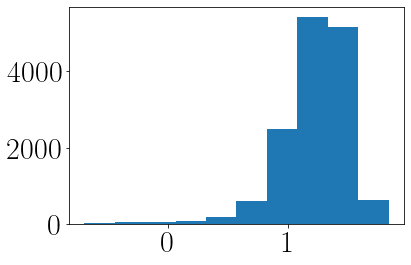

In [4]:
plt.hist(np.log10(gaia_mc.Prot));

In [26]:
# dt, dp = 250, .15
dt, dp = 600, .2

dispersions_bins = aviary.calc_dispersion_bins(gaia_mc.color_teffs.values,
                                               np.log10(gaia_mc.Prot.values),
                                               gaia_mc.vb.values,
                                               dt, dp)

100%|██████████| 14750/14750 [00:03<00:00, 4128.01it/s]


(3, 75)

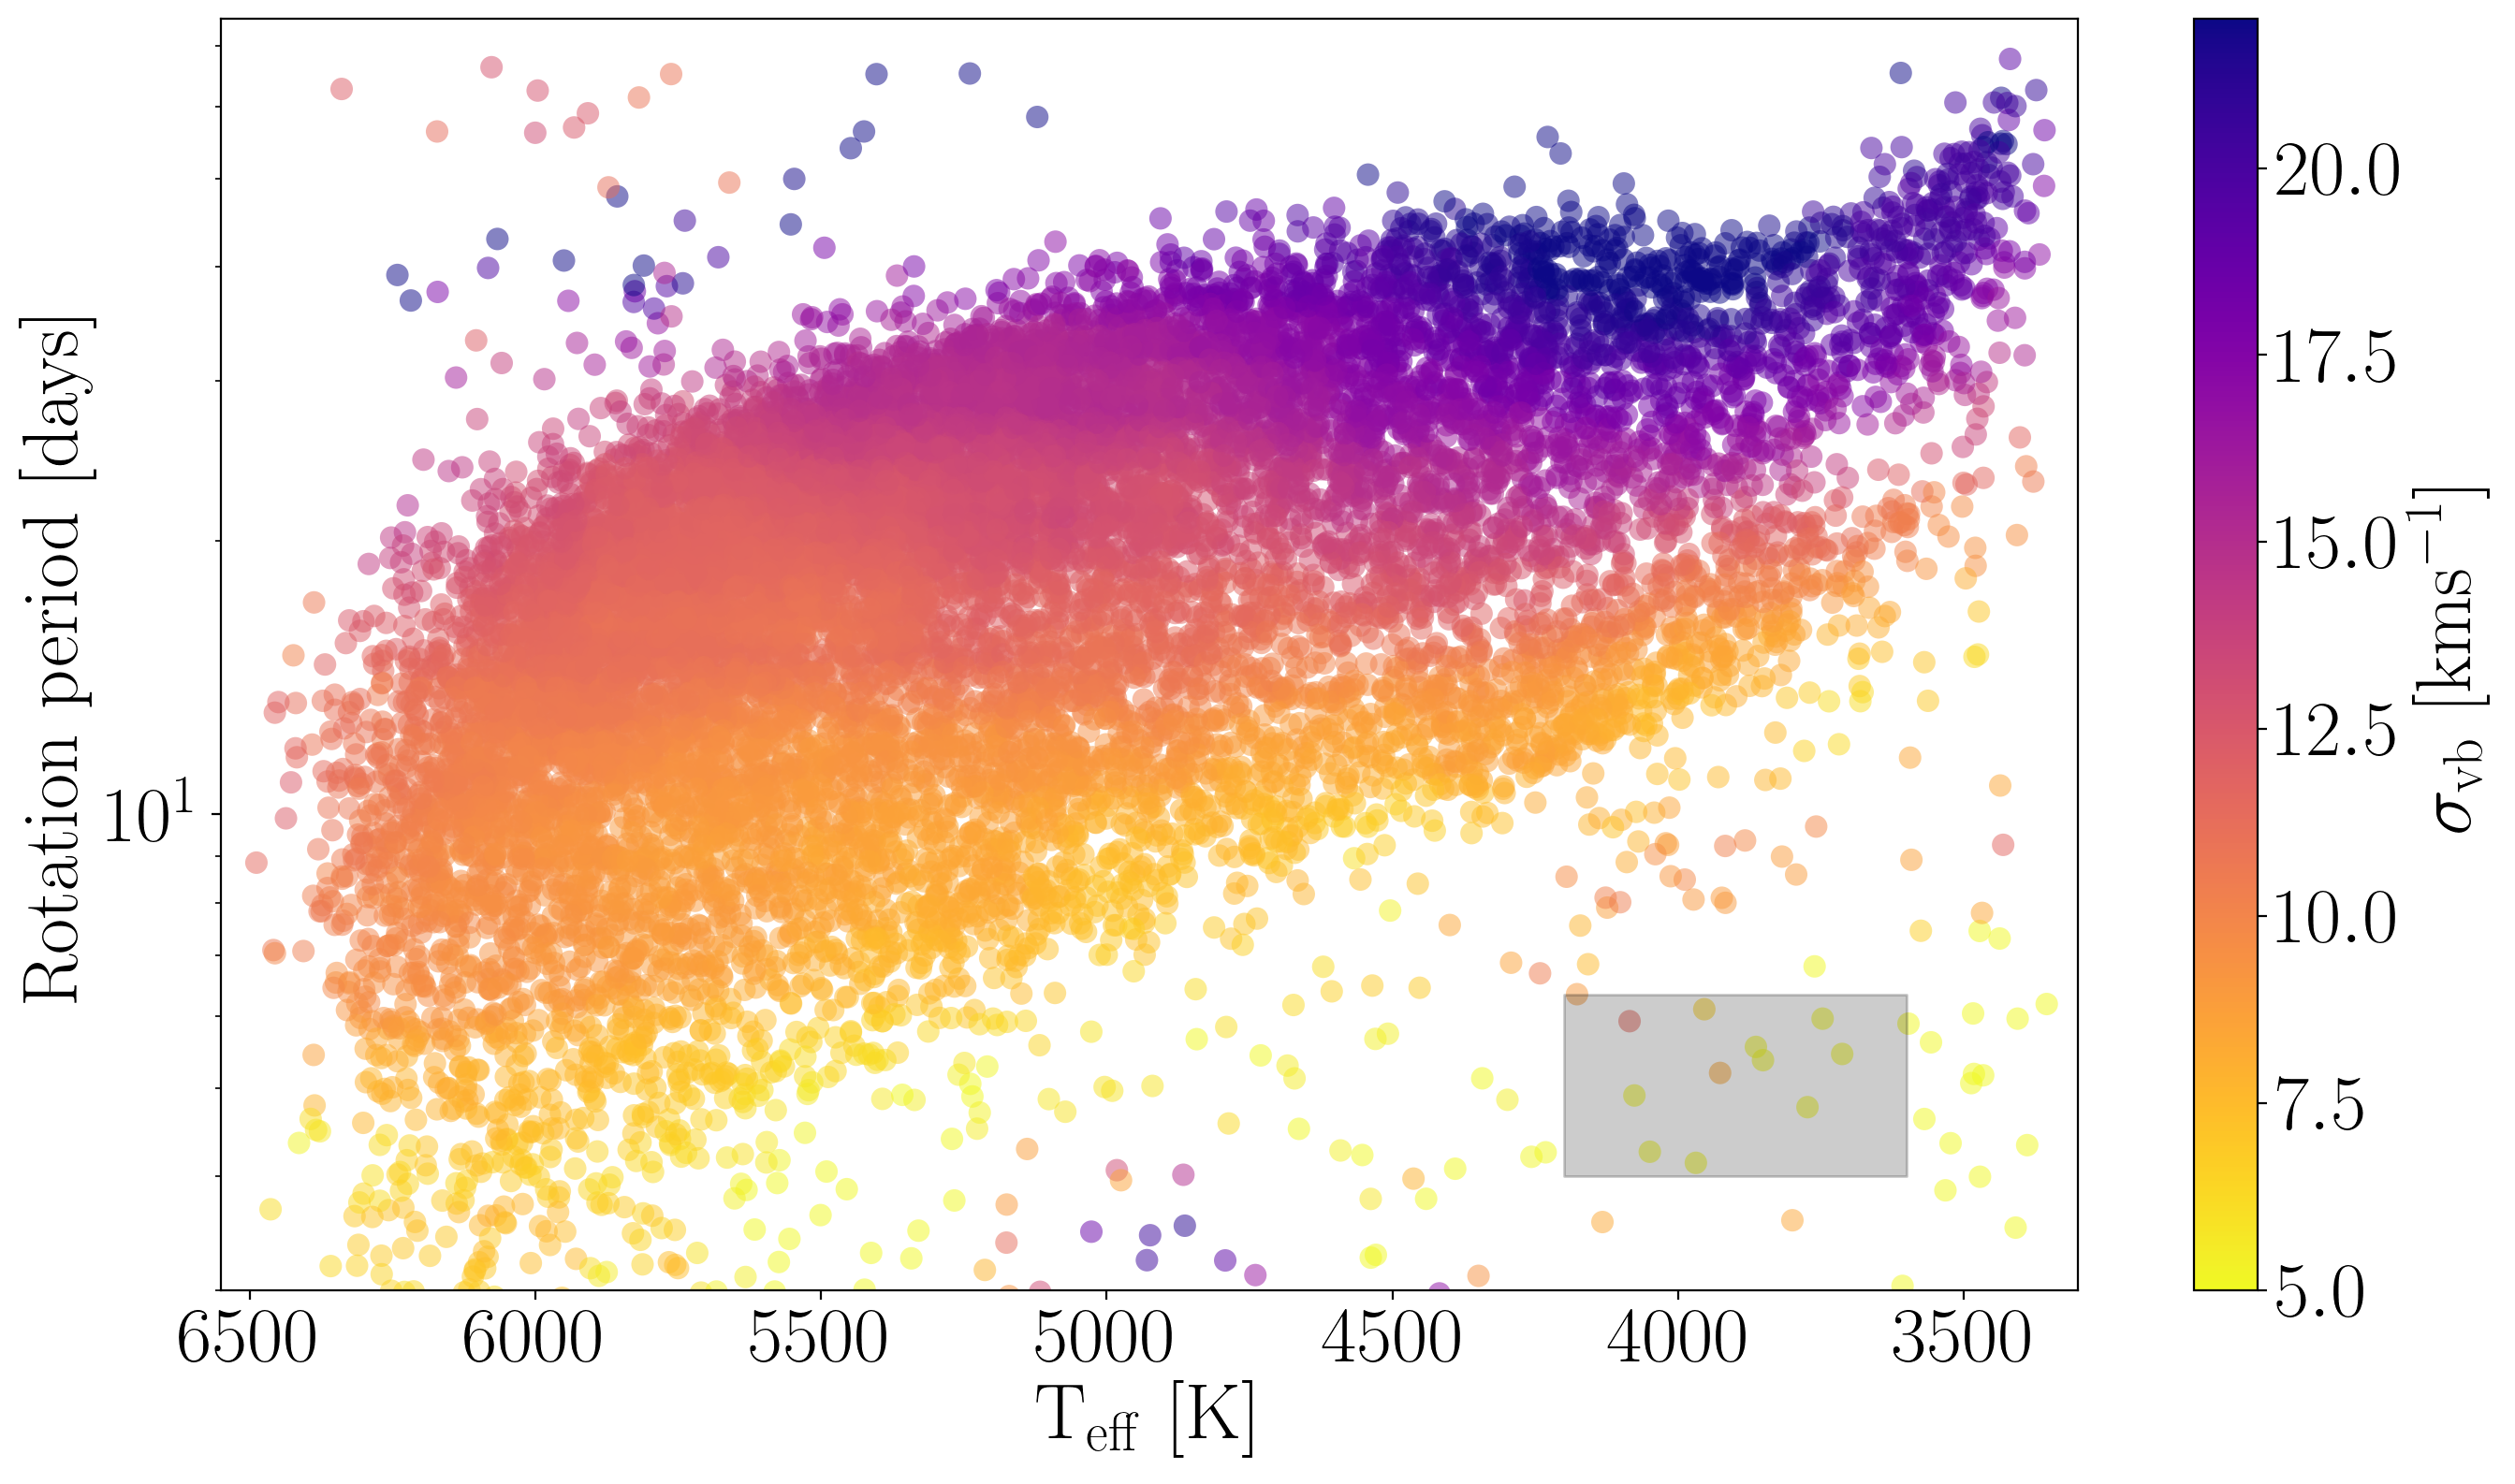

In [27]:
plt.figure(figsize=(16, 9), dpi=200)

plt.scatter(gaia_mc.color_teffs, gaia_mc.Prot, c=dispersions_bins,
            s=75, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r", zorder=1)
plt.yscale("log")
plt.xlim(6550, 3300)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

color_bar = plt.colorbar(label="$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
color_bar.set_alpha(1)
color_bar.draw_all()

xs = np.arange(3000, 6000, dt)
ys = 10**np.arange(1, 2, dp)
    
xspot, yspot = 3600, 4
xs = np.linspace(xspot, xspot+dt, 100)
plt.fill_between(xs, yspot, 10**(np.log10(yspot) + dp), color="k", alpha=.2)

plt.ylim(3, 75)

(3, 75)

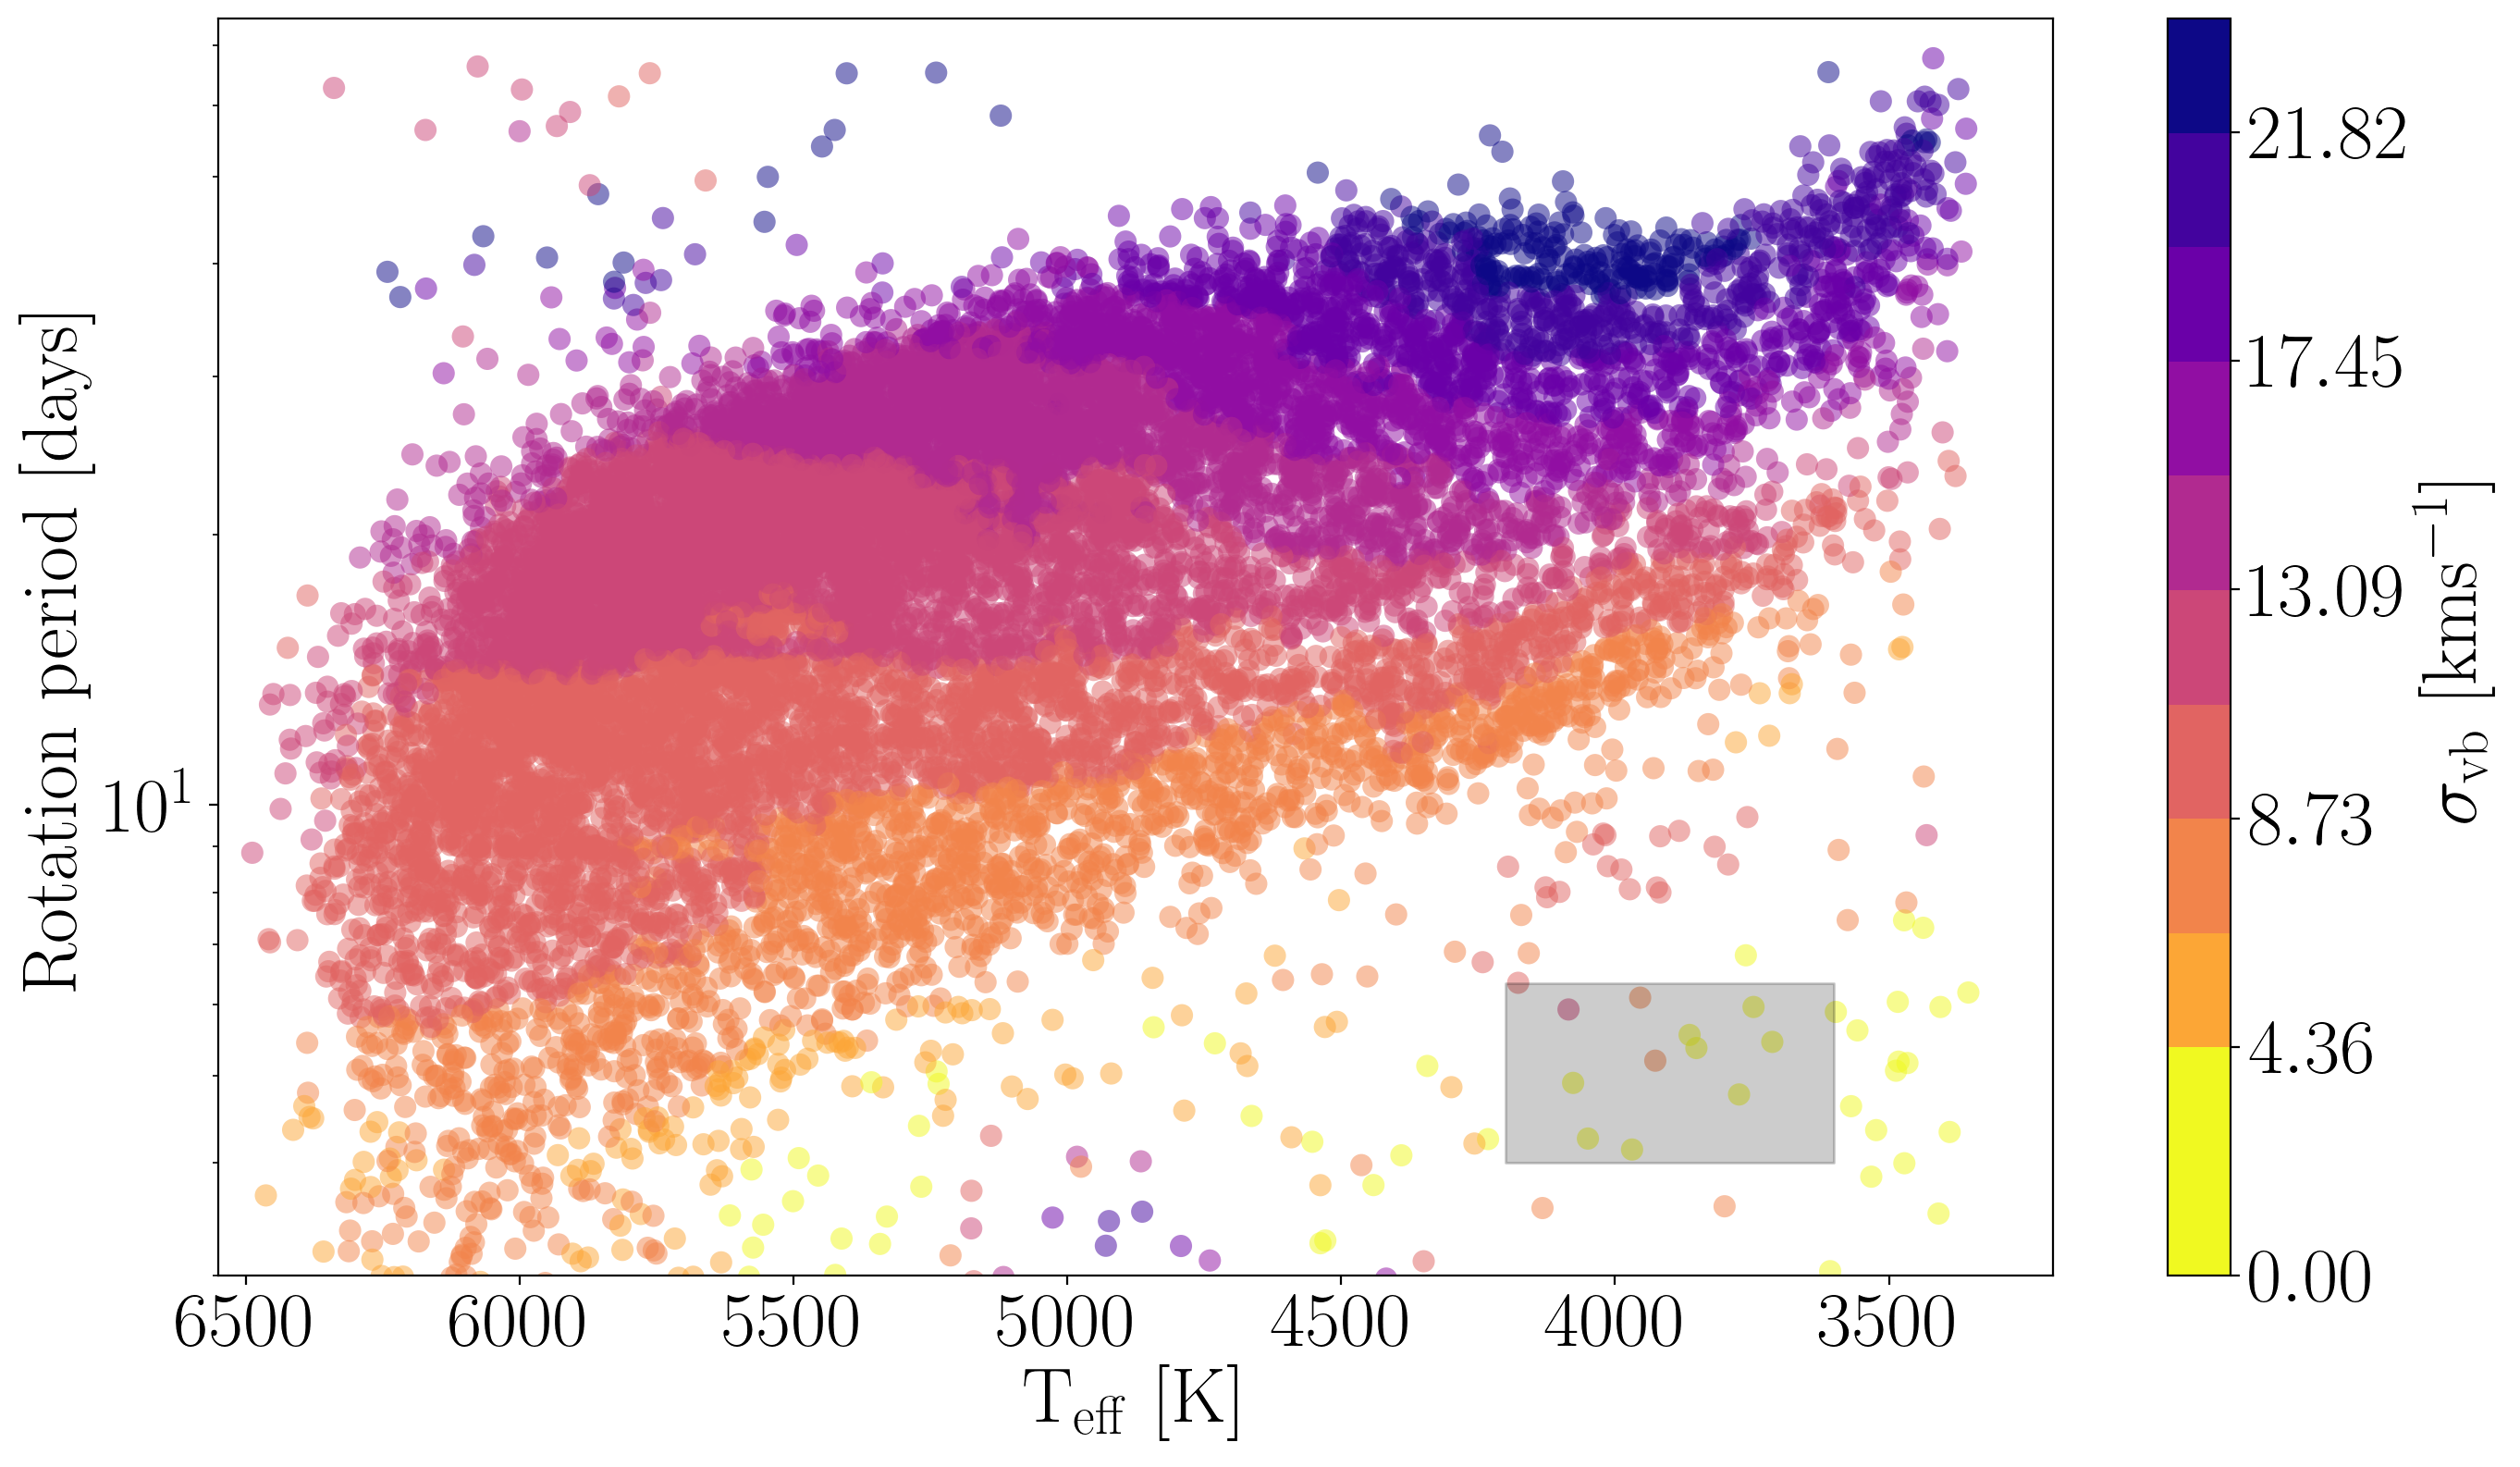

In [32]:
cmap = plt.cm.plasma_r
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 24, 12)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(16, 9), dpi=200)

plt.scatter(gaia_mc.color_teffs, gaia_mc.Prot, c=dispersions_bins,
            s=75, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap=cmap, norm=norm, zorder=1)
plt.yscale("log")
plt.xlim(6550, 3200)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

color_bar = plt.colorbar(label="$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
color_bar.set_alpha(1)
color_bar.draw_all()

xs = np.arange(3000, 6000, dt)
ys = 10**np.arange(1, 2, dp)
    
xspot, yspot = 3600, 4
xs = np.linspace(xspot, xspot+dt, 100)
plt.fill_between(xs, yspot, 10**(np.log10(yspot) + dp), color="k", alpha=.2)

plt.ylim(3, 75)

(3, 75)

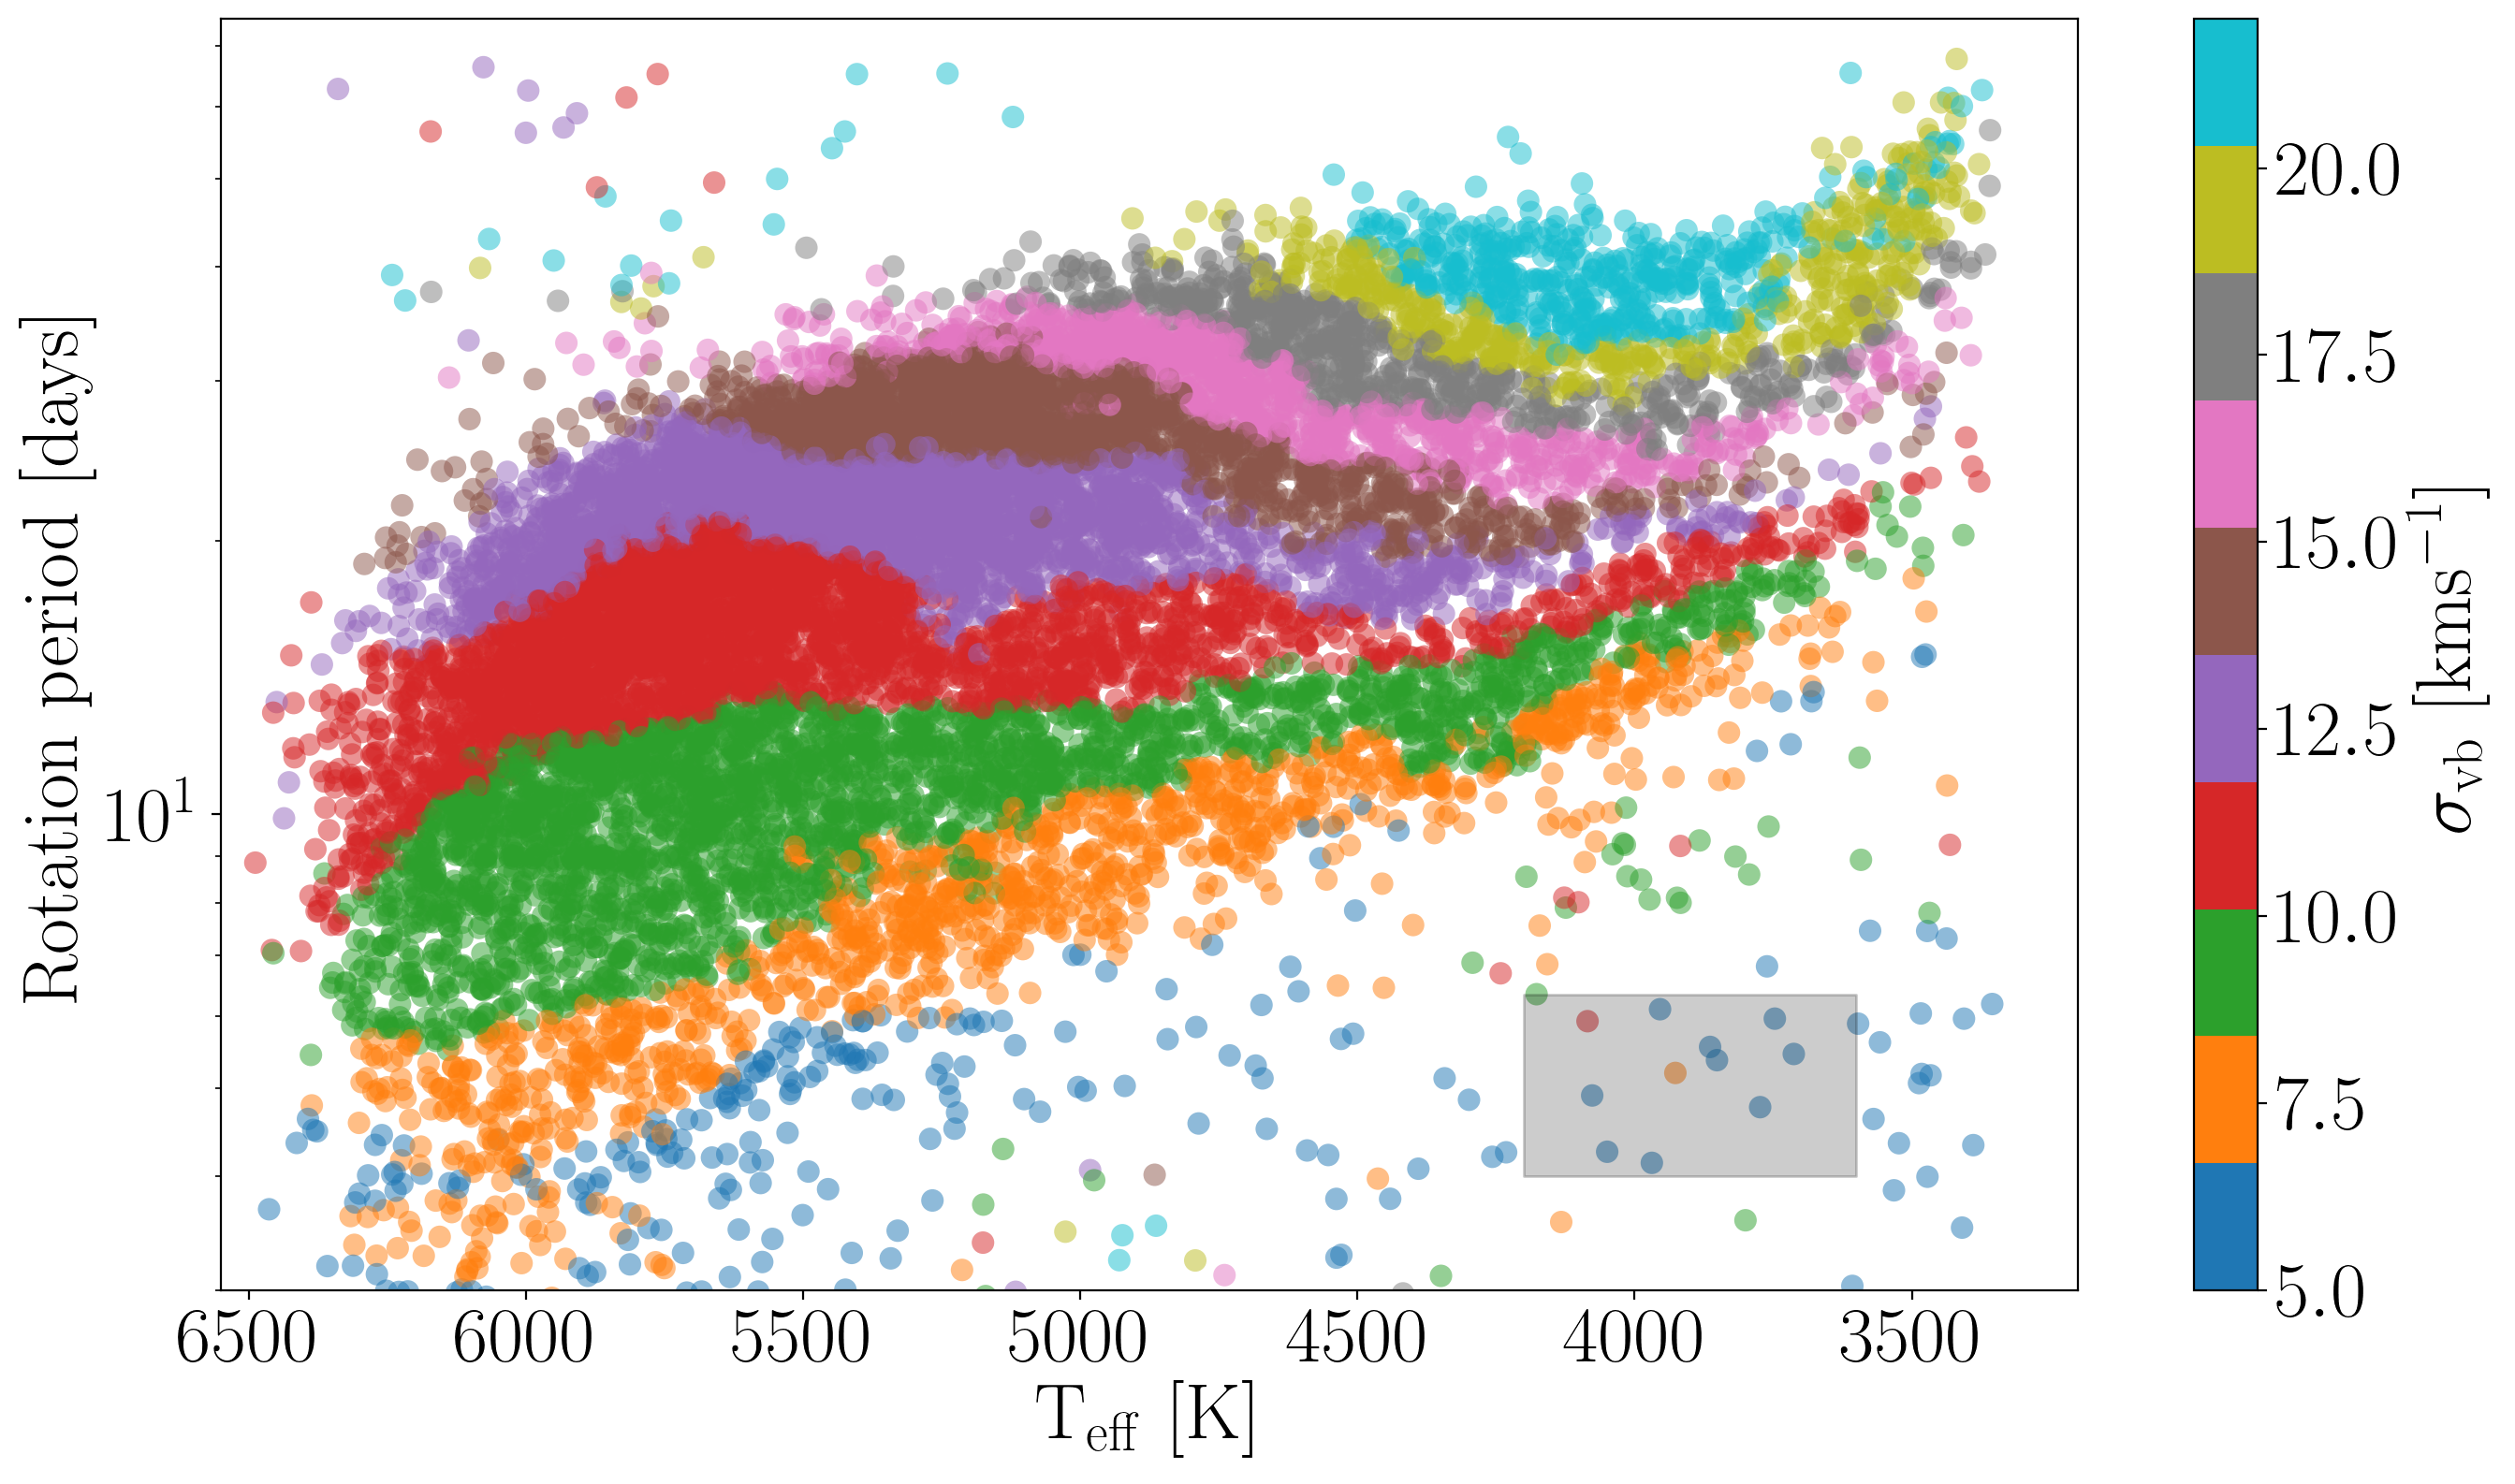

In [33]:
plt.figure(figsize=(16, 9), dpi=200)

plt.scatter(gaia_mc.color_teffs, gaia_mc.Prot, c=dispersions_bins,
            s=75, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="tab10", zorder=1)
plt.yscale("log")
plt.xlim(6550, 3200)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

color_bar = plt.colorbar(label="$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
color_bar.set_alpha(1)
color_bar.draw_all()

xs = np.arange(3000, 6000, dt)
ys = 10**np.arange(1, 2, dp)
    
xspot, yspot = 3600, 4
xs = np.linspace(xspot, xspot+dt, 100)
plt.fill_between(xs, yspot, 10**(np.log10(yspot) + dp), color="k", alpha=.2)

plt.ylim(3, 75)

In [34]:
gaia_mc["vb_dispersion"] = dispersions_bins
gaia_mc.to_csv("gaia_mcquillan_dispersion.csv")

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
dt, dp = 400, .3

dispersions_bins = aviary.calc_dispersion_bins(gaia_mc.color_teffs.values,
                                               np.log10(gaia_mc.Prot.values),
                                               gaia_mc.vb.values,
                                               dt, dp)

100%|██████████| 14750/14750 [00:03<00:00, 4679.34it/s]


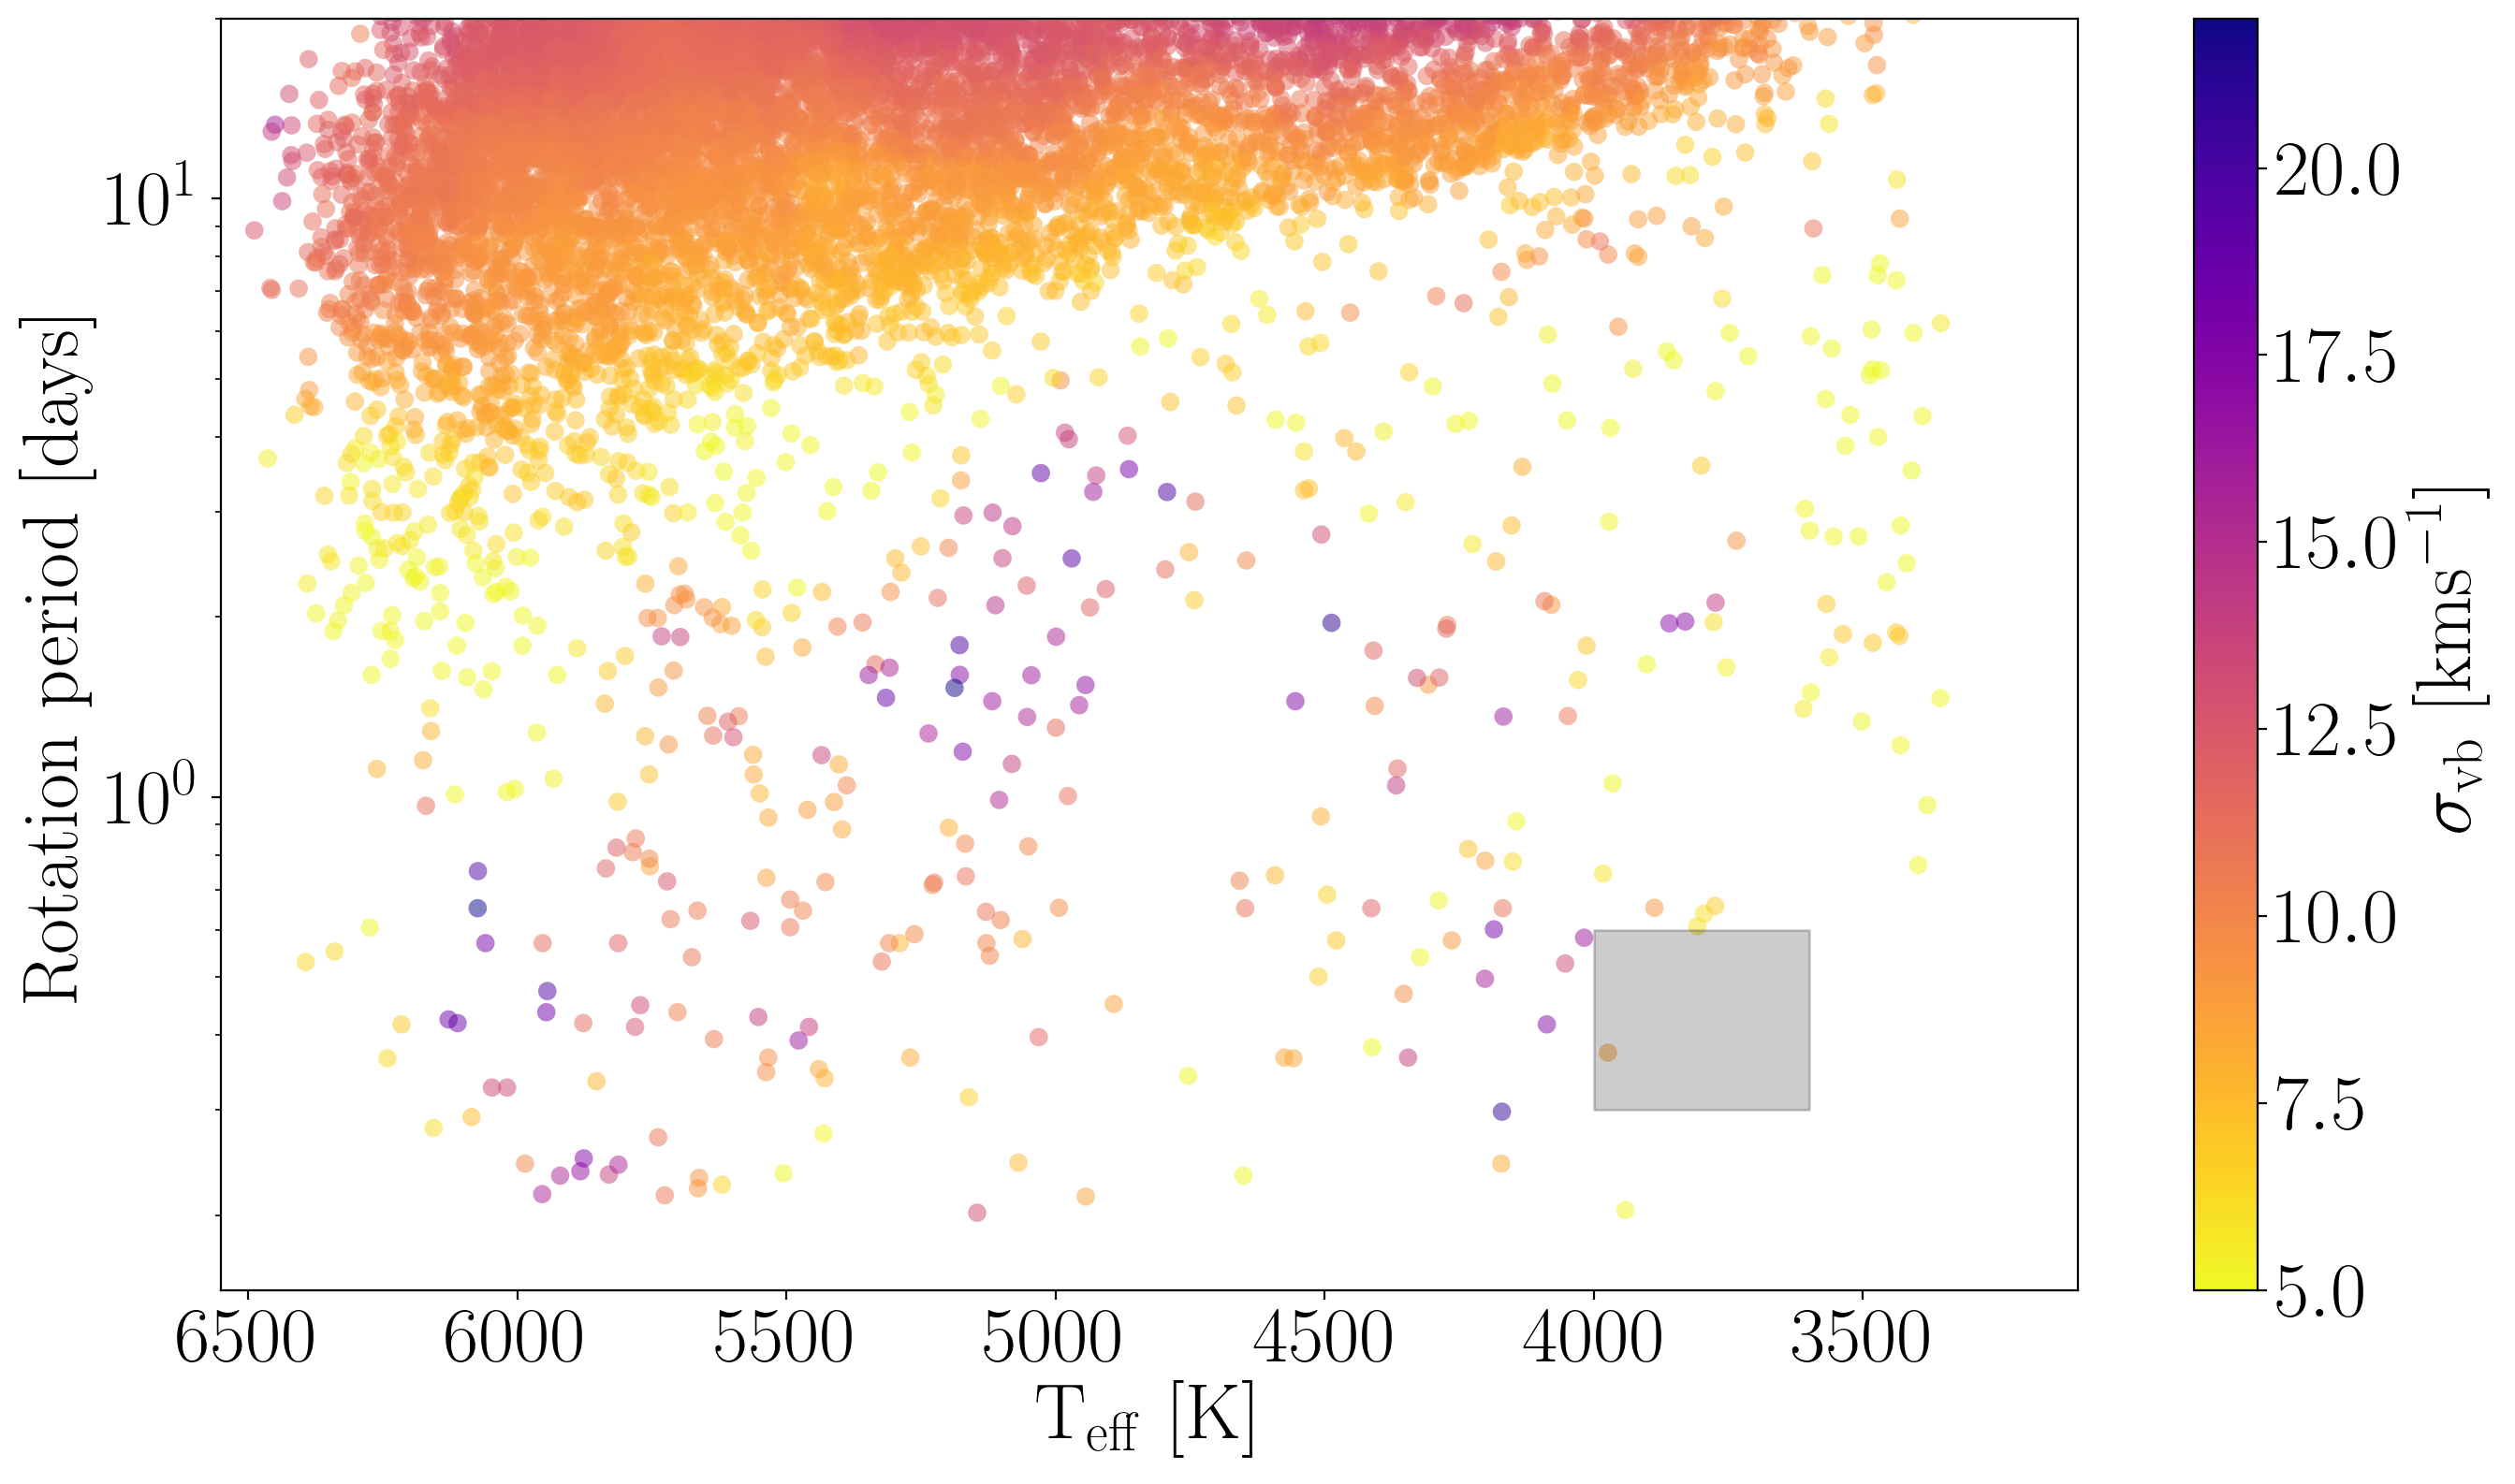

In [74]:
plt.figure(figsize=(16, 9), dpi=200)

plt.scatter(gaia_mc.color_teffs, gaia_mc.Prot, c=dispersions_bins,
            s=50, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r", zorder=1)
plt.yscale("log")
plt.xlim(6550, 3100)
plt.ylim(.15, 20)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

color_bar = plt.colorbar(label="$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
color_bar.set_alpha(1)
color_bar.draw_all()
    
xspot, yspot = 3600, .3
xs = np.linspace(xspot, xspot+dt, 100)
plt.fill_between(xs, yspot, 10**(np.log10(yspot) + dp), color="k", alpha=.2)

Text(0, 0.5, 'Rotation period [days]')

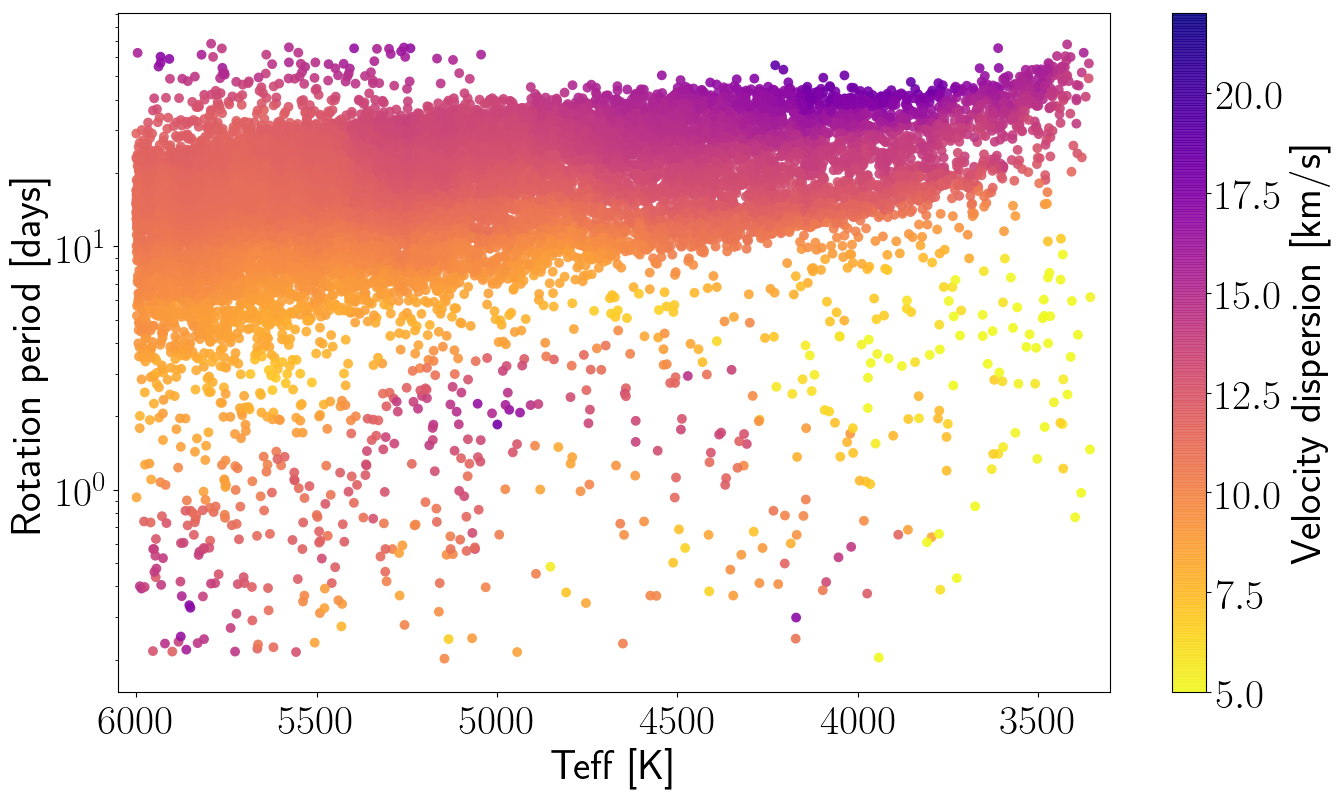

In [37]:
plt.figure(figsize=(16, 9), dpi=100)
teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp

plt.scatter(teff_scaled, 10**p_scaled, c=dispersions_bins, s=50, alpha=.9, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar(label="Velocity dispersion [km/s]")
plt.xlim(6050, 3300)
plt.xlabel("Teff [K]")
plt.ylabel("Rotation period [days]")

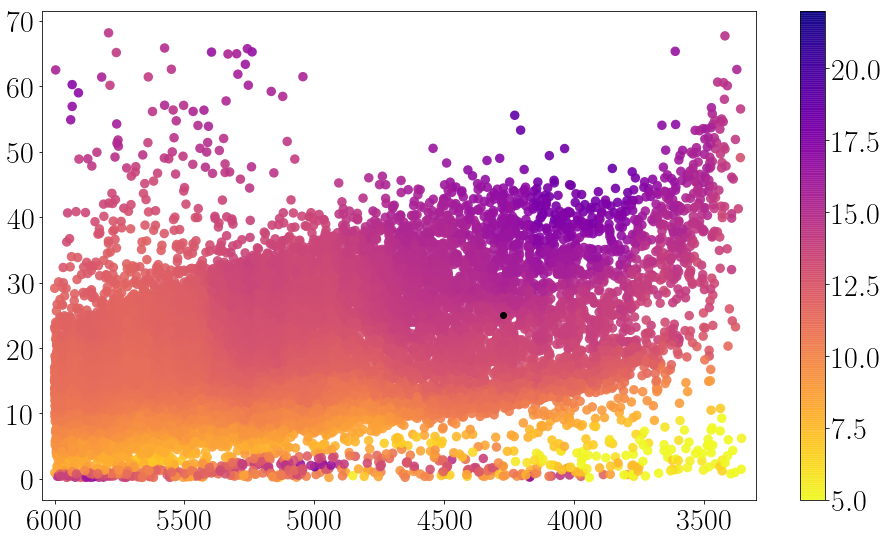

In [26]:
plt.figure(figsize=(16, 9))
teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp

plt.scatter(teff_scaled, 10**p_scaled, c=dispersions_bins, s=90, alpha=.9, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
# plt.yscale("log")
plt.colorbar()
plt.xlim(6050, 3300)
plt.plot(4275, 25, "ko")

Plot temperature slices.

Text(0, 0.5, 'Rotation period')

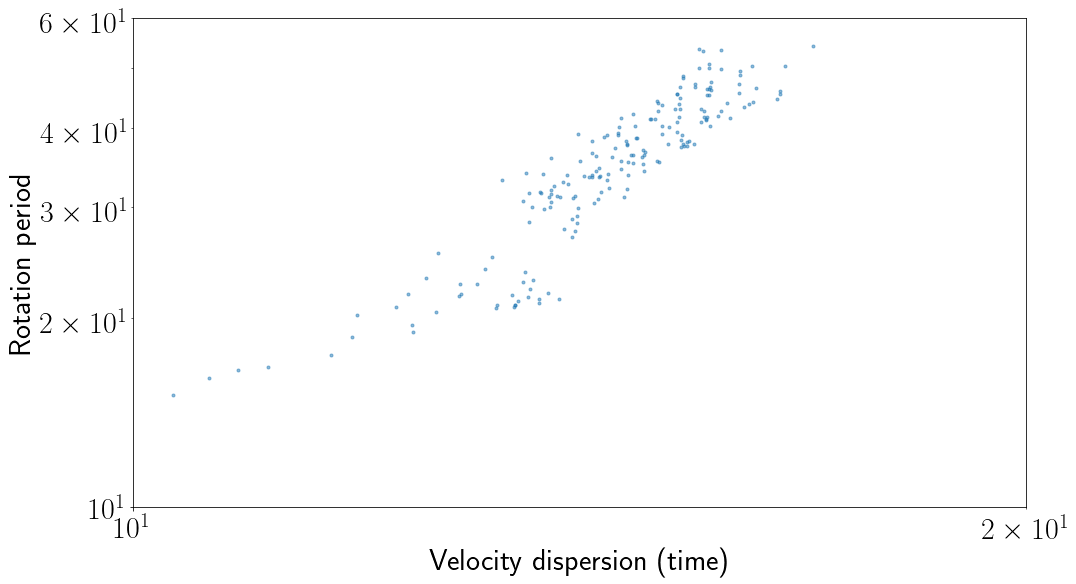

In [15]:
m = (4250 < teff_scaled) * (teff_scaled < 4300)

plt.figure(figsize=(16, 9))
# plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)
plt.xscale("log")
plt.yscale("log")
plt.xlim(5, 60)
# plt.axvline(25)

m = (4200 < teff_scaled) * (teff_scaled < 4250)
# plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)

m = (3500 < teff_scaled) * (teff_scaled < 3650)
# plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)
plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)


plt.xlim(10, 20)
plt.ylim(10, 60)

plt.xlabel("Velocity dispersion (time)")
plt.ylabel("Rotation period")

Text(0, 0.5, 'Rotation period [days]')

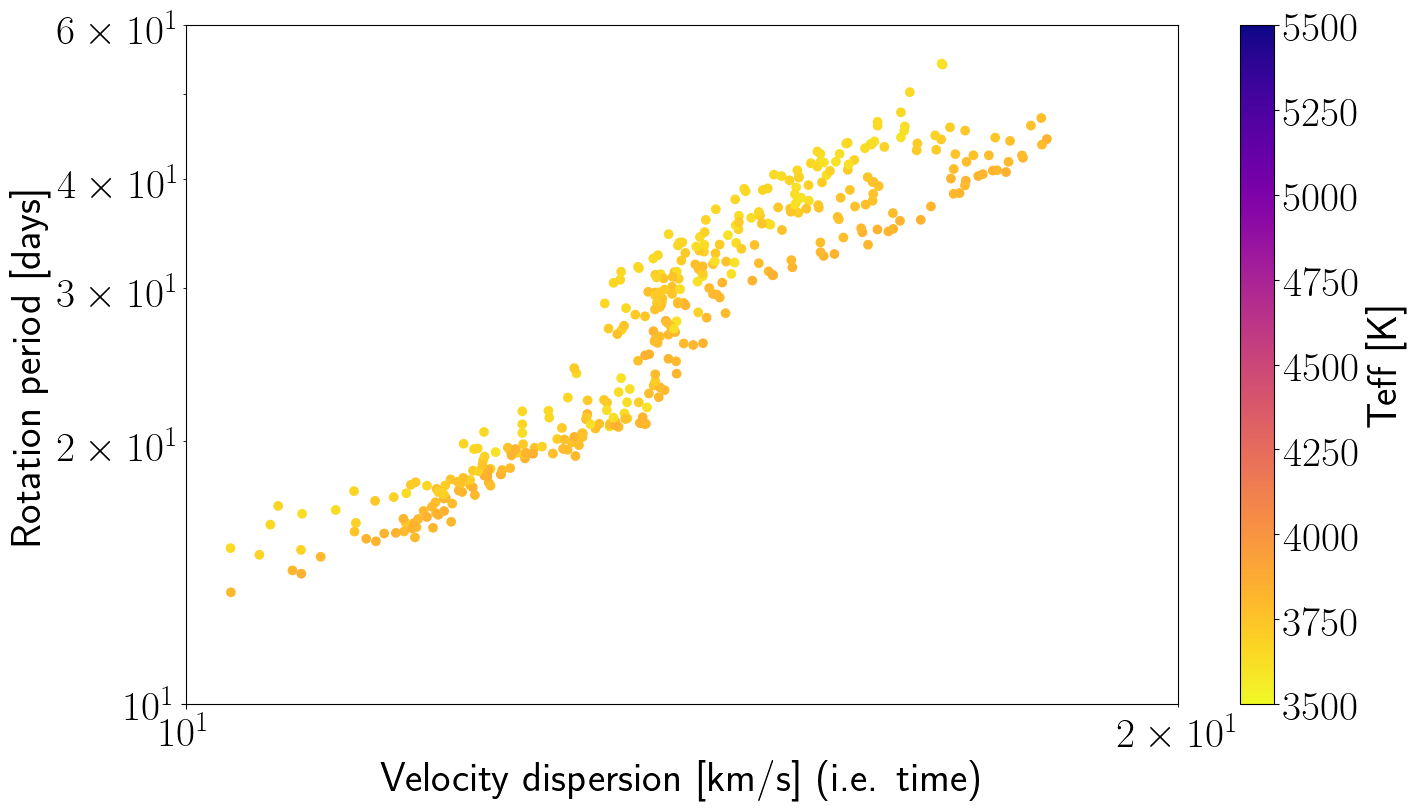

In [36]:

plt.figure(figsize=(16, 9), dpi=100)
plt.xscale("log")
plt.yscale("log")
plt.xlim(5, 60)
# plt.axvline(25)

m = (3600 < teff_scaled) * (teff_scaled < 3850)
plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=teff_scaled[m], alpha=1, vmin=3500, vmax=5500, cmap="plasma_r")

plt.colorbar(label="Teff [K]")

plt.xlim(10, 20)
plt.ylim(10, 60)

# plt.axhline(25)

plt.xlabel("Velocity dispersion [km/s] (i.e. time)")
plt.ylabel("Rotation period [days]")

Text(0, 0.5, 'Rotation period [days]')

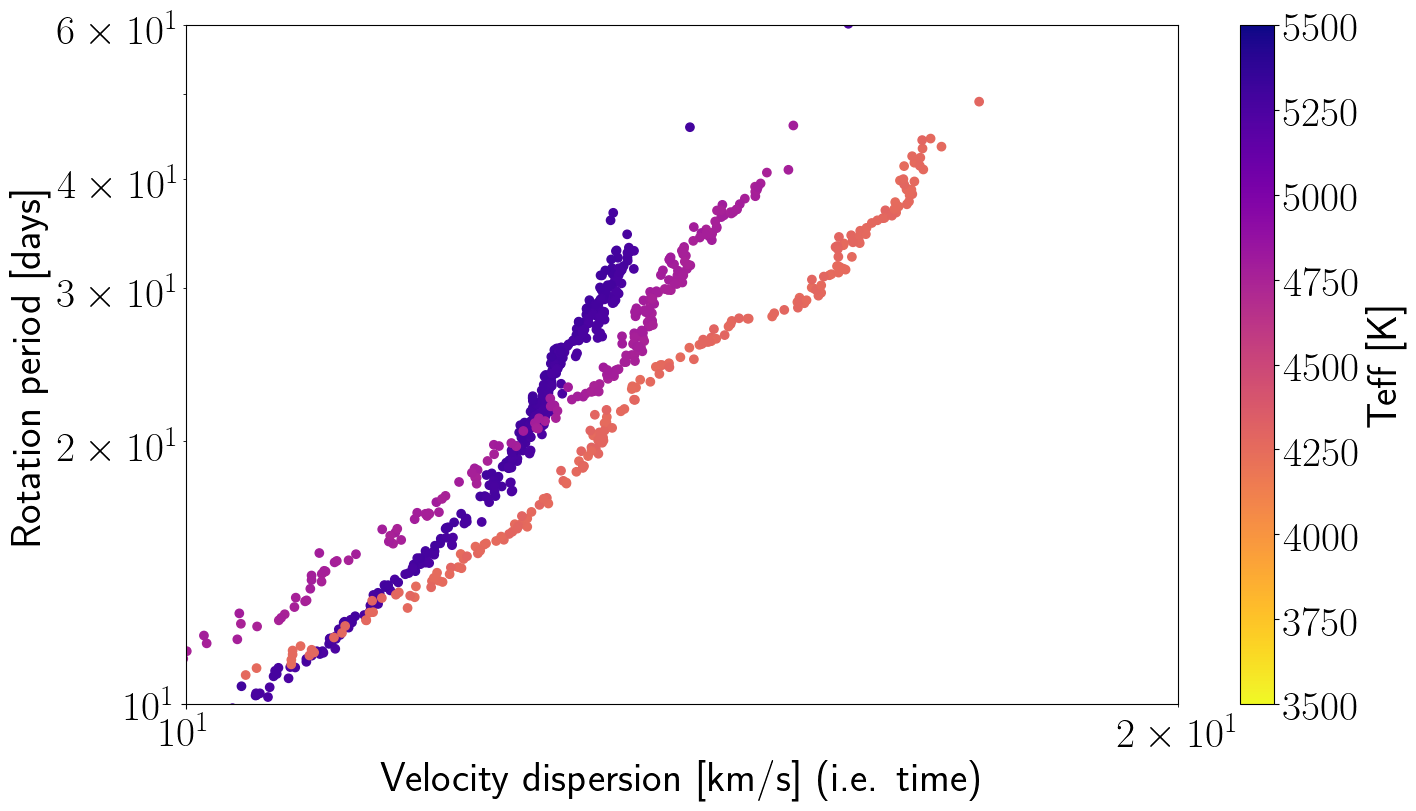

In [35]:
plt.figure(figsize=(16, 9), dpi=100)
plt.xscale("log")
plt.yscale("log")
plt.xlim(5, 60)
# plt.axvline(25)

m = (5250 < teff_scaled) * (teff_scaled < 5300)
plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=teff_scaled[m], alpha=1, vmin=3500, vmax=5500, cmap="plasma_r")

m = (4750 < teff_scaled) * (teff_scaled < 4800)
plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=teff_scaled[m], alpha=1, vmin=3500, vmax=5500, cmap="plasma_r")

m = (4250 < teff_scaled) * (teff_scaled < 4300)
plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=teff_scaled[m], alpha=1, vmin=3500, vmax=5500, cmap="plasma_r")

plt.colorbar(label="Teff [K]")

plt.xlim(10, 20)
plt.ylim(10, 60)

# plt.axhline(25)

plt.xlabel("Velocity dispersion [km/s] (i.e. time)")
plt.ylabel("Rotation period [days]")

Text(0, 0.5, 'Rotation period')

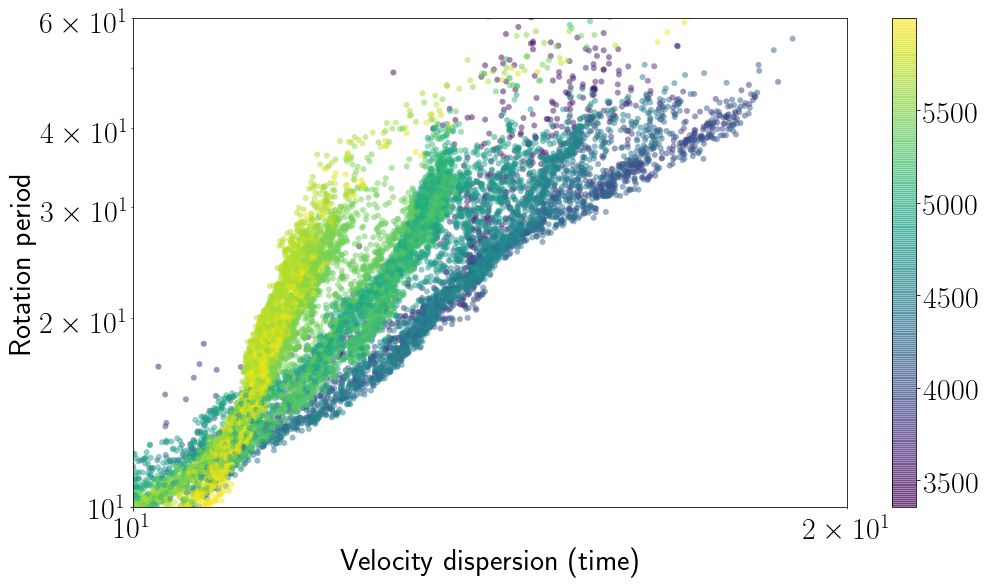

In [385]:
plt.figure(figsize=(16, 9))
plt.xscale("log")
plt.yscale("log")
plt.xlim(5, 60)
# plt.axvline(25)

# m = (5250 < teff_scaled) * (teff_scaled < 5300)
# plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=np.log10(gaia_mc.Rper.values[m]), vmin=3.2, vmax=4.5)

# m = (4750 < teff_scaled) * (teff_scaled < 4800)
# plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=np.log10(gaia_mc.Rper.values[m]), vmin=3.2, vmax=4.5)

# m = (4250 < teff_scaled) * (teff_scaled < 4300)
# plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=np.log10(gaia_mc.Rper.values[m]), vmin=3.2, vmax=4.5)

# m = (3600 < teff_scaled) * (teff_scaled < 3850)
# plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=np.log10(gaia_mc.Rper.values[m]), vmin=3.2, vmax=4.5)

# plt.scatter(dispersions_bins, 10**p_scaled, c=np.log10(gaia_mc.Rper.values), vmin=3.2, vmax=4.5, alpha=.5, edgecolor="")
plt.scatter(dispersions_bins, 10**p_scaled, c=gaia_mc.color_teffs.values, alpha=.5, edgecolor="")


plt.xlim(10, 20)
plt.ylim(10, 60)
plt.colorbar()

plt.xlabel("Velocity dispersion (time)")
plt.ylabel("Rotation period")

# Low variability when spin-down is increasing, high variability when spin down is decreasing.

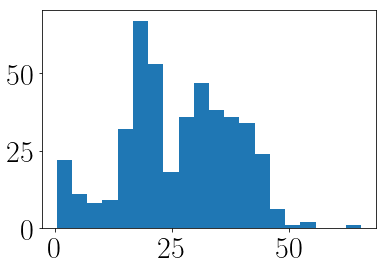

In [368]:
plt.hist(10**p_scaled[m], 20);

100%|██████████| 7262/7262 [00:01<00:00, 6636.89it/s]


(8, 70)

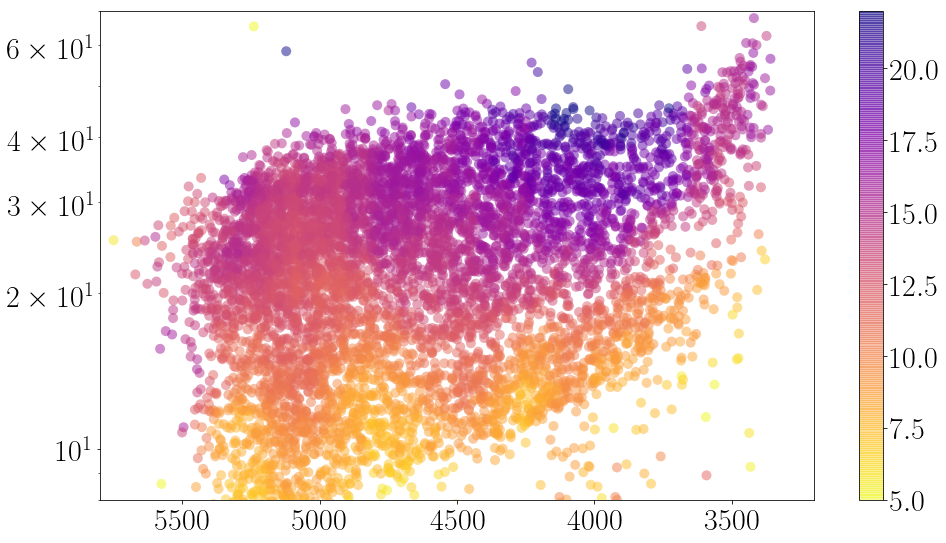

In [276]:
m = gaia_mc.flag.values == 1

dispersions_bins = calc_dispersion_bins(x[m], y[m], z[m], .08, .12)

plt.figure(figsize=(16, 9))
plt.scatter(teff_scaled[m], 10**p_scaled[m], c=dispersions_bins, s=100, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar()
plt.xlim(5800, 3200)
plt.ylim(8, 70)

In [277]:
dispersions_nearest = calc_dispersion_nearest(x, y, z, 30)

100%|██████████| 15952/15952 [00:18<00:00, 868.32it/s]


(6050, 3300)

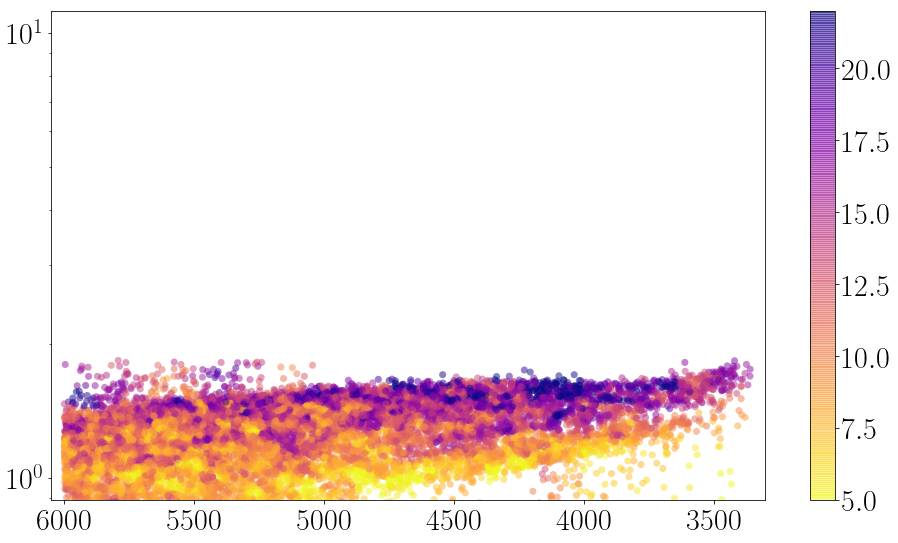

In [279]:
plt.figure(figsize=(16, 9))
# teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp
plt.scatter(teff_scaled, p_scaled, c=dispersions_nearest, s=50, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar()
plt.xlim(6050, 3300)

(array([ 324.,  556.,  831., 1124., 1210., 1428., 1849., 2114., 2366.,
        2222.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

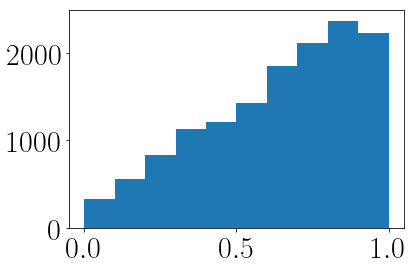